<h1 align="justify"> Resistive ADC Modelling and High-Level Simulation </h1>

<p align="justify"> 
In this notebook, three architectures of ADC are modelled and an high level simulation is performed for each architecture. 
The covered ADC architectures are based in resistive arrays to enable the discretization of the reference voltage in 
each discrete votlage level, implementing the intrinsic DAC of the ADC. The generality of the existing ADC architectures 
are based on the use of a comparator to effectively digitize the input votlage. This notebook will have a special enphasis 
on the impact of the comparator offset in the ADC performance. 
</p>

<h2 align="left"> Comparators: A brief introduction </h2>

<p align="justify">
A comparator can be thought of a 1 bit ADC. If the input voltage of the ADC (at v+) is higher than the reference voltage of the comparator (at v-), the comparator will output a bit with a logical value of '1', whereas if the input voltage is lower than the reference voltage, the comparator will output a bit with a logical value of '0'.
</p>

<p align="center">
    <img src="../docs/imgs/comparator.png" width=450 text="comparator"/>
</p>

<p align="justify">
The higher the gain of the comparator, the faster is the transition between the two possible logical values at the output. Thus, comparators usually employ:
<ul>
<il>Positive feedback</il>

<il>Clock reset</il>
</ul> 

to ensure very high gains and fast transitions due to the instability of the comparator itself, using the clock reset to re-establish the correct operating point of the comparator.
</p>

<h3 align="left"> The main problem with Comparators </h3>

<p align="justify">
The input of almost every comparator topology is based on the use of a differential pair. Due to mismatching, the employed transistors in the implementation of the input differential pair usually present different gate width and length dimensions, which ultimately affects the DC operating point of the comparator. This mismatching leads to a voltage offset between both inputs of the comparator. Of course that this offset is also present at the output of the circuit, once a comparator is basically an unstable amplifier with a "linear" response.
</p>

<p align="center">
    <img src="../docs/imgs/par_diff.png" width=450 text="comparator-ofst"/>
</p>

Considering that the gate area mismatch is a random variable following a normal distribution, the voltage offset arising through the differential pair mismatch can be given by the standard error $\sigma_{ofst} \approx V_{ofst} $:

$$ \sigma_{ofst} = \sqrt{ \frac{A^2_{V_{TH}}}{W.L} + \frac{A^2_{\beta}}{W.L} \left( \frac{V_{GS} - V_{TH} }{2} \right) } $$

where $A_{V{TH}}$ and $A_\beta$, with $\beta = \mu.C_{ox}$ are technology-specific parameters modelling how the threshhold voltage $V_{TH}$ and the channel mobility $\mu.C_{ox}$ vary with the gate area of the transistor.

<p align="justify">
The offset will lead the comparator to decide its output logical value relative to a lower (negative offset) or higher (positive ofset) input voltage than the reference voltage. This offset is usually modelled as a random variable following a normal distribution with a mean of zero and a standard deviation equal to the maximum offset amplitude (Vofst). The decisions happening "sooner" or "later", in relation to the voltage reference, will provoke missing-codes in the ADC's transfer function.
</p>

In [710]:
from functools import partial

# mathematical computing
import numpy as np
import scipy as sp
from scipy import signal # to generate the noise signal
import seaborn as sns # to observe the noise signal's histogram

sns.set_theme()
sns.set_palette("colorblind")

from numpy.random import uniform, normal # random numbers fitted into a uniform distribution
# plotting
import matplotlib.pyplot as plt
# import the models and utilities functions
from utils import ideal_dac, ideal_adc, nonideal_adc, dec2bin, bin2dec

%matplotlib inline

In [711]:
# number of simulation points
npoints = 1000
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,npoints)*Ts; # (0:Np-1) == np.arange(0,Np)

<h2 align="left"> Flash ADC - Modelling </h2>

<p align="center">
    <img src="../docs/imgs/flash_adc.png" width=450 text="flash_adc"/>
</p>

In [712]:
# tech parameters
Avth = 1e-8
Abeta = 1e-8
# comparator device level parameters
vddd = 0.9
vssd = 0.0
vcm = (vddd + vssd)/2
vs = 0.020
vgs = vcm - vs
vth = 0.330
nm = 1e-9
um = 1e-6
w = 20*um
l = 30*nm
# comparator offset standard error

std_ofst = np.sqrt( (Avth**2)/(w*l) + ((Abeta**2)/(w*l))*((vgs-vth)/2) )

In [713]:
# setup the adc parameters
nbits = 8
vref = vddd
vlsb = vref/(2**nbits)

# setup the resistor array
ru = 1e3
res = np.ones(2**nbits)*ru
# resistance mismatch in ohm, following a normal distribution
u_err = 0.0
sigma = 5
u_std = 1/sigma # 33% of the unit resistance for a semiconductor resistor
r_err = normal(u_err, u_std**2, len(res))
res = res + r_err*ru
assert len(res) == 2**nbits

# setup vlsb voltage array from resistor array using a voltage divider
vcomps = np.array([
    vref*(np.sum(res[0:i+1])/np.sum(res)) for i in range(len(res)-1)
])
# setup the comparator offset array
comps_ofst = np.random.normal(0, std_ofst**2, len(vcomps))
comps = vcomps + comps_ofst
assert len(comps) == 2**nbits-1, "The number of comparators is not correct: %d" % len(comps)


Text(0.5, 1.0, 'comparator reference voltage distribution (V) - (red)')

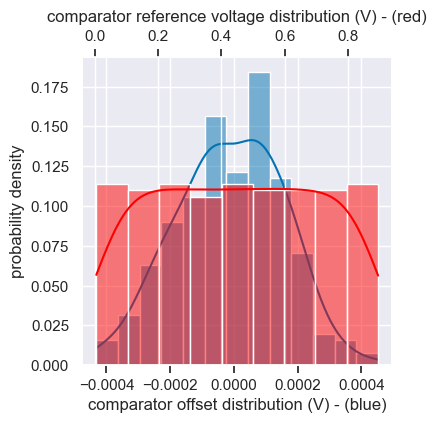

In [714]:
# observe the comparator offset histogram
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(comps_ofst, ax=ax, stat="probability", kde=True)
sns.histplot(comps, ax=ax.twiny(), stat="probability", kde=True, color='red')
ax.set_xlabel('comparator offset distribution (V) - (blue)')
ax.set_ylabel('probability density')
ax.grid(True)
ax.set_title('comparator reference voltage distribution (V) - (red)')

Text(0.5, 1.0, 'resistor values mismatch distribution')

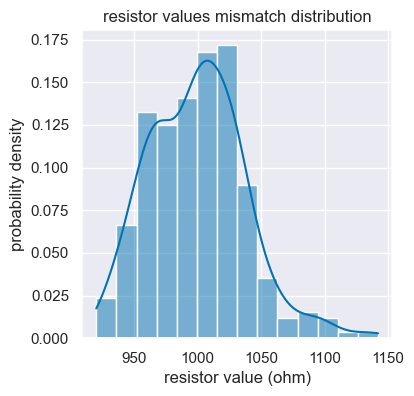

In [715]:
# observe the resistor mismatch histogram
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(res, ax=ax, stat="probability", kde=True)
ax.set_xlabel('resistor value (ohm)')
ax.set_ylabel('probability density')
ax.grid(True)
ax.set_title('resistor values mismatch distribution')

In [716]:
# observe the output code throughout time
vdd = vref # V
nbits = 8 # number of bits
vlsb = np.abs(vref / (2**nbits) ) # V
# number of simulation points
Np = 2**15
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)
# setup the input codes
A1 = vdd/2
f1 = (Fs/Np) # Hz
ph1 = 0 # rad
ofst = 0.0
vin_t = A1*np.sin(2*np.pi*f1*tD + ph1) + ofst + vdd/2
# generate the output data signal from an input signal
decoder_in_t = np.array([v > comps for v in vin_t])
dout_t = np.array([np.count_nonzero(din) for din in decoder_in_t])

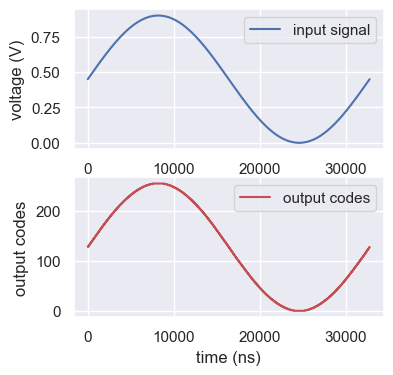

In [717]:
# represent the input signal and codes
ns = 1e-9
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].plot(tD/ns, vin_t, 'b', label='input signal')
ax[0].set_xlabel('time (ns)')
ax[0].set_ylabel('voltage (V)')
ax[0].legend()
ax[1].plot(tD/ns, dout_t, 'r', label='output codes')
ax[1].set_xlabel('time (ns)')
ax[1].set_ylabel('output codes')
ax[1].legend()
#ax[0].set_xlim([0, (1/(f1))/ns])
#ax[1].set_xlim([0, (1/(f1))/ns])
ax[1].grid(True); ax[0].grid(True)

In [718]:
# observe the adc transfer function
# generate the output data signal from an input signal
vin = np.sort(np.unique(vin_t))
decoder_in = np.array([v > comps for v in vin])
dout = np.array([np.count_nonzero(din) for din in decoder_in])
vtrans = vin[np.where(np.diff(dout) > 0)]
dout = dout[np.where(np.diff(dout) > 0)]
decoder_in, dout


(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 1

Text(0.5, 1.0, 'Flash ADC Transfer Function')

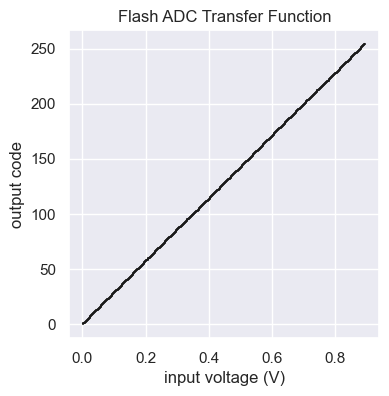

In [719]:
# plot the transfer function of the flash adc
# plot the output voltage in function of the input code
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.step(vtrans, dout, 'k', label='output codes')
ax.set_xlabel('input voltage (V)')
ax.set_ylabel('output code')
ax.grid(True)
ax.set_title('Flash ADC Transfer Function')

In [720]:
# compute the transition input voltages
# compute the INL and DNL of the ADC
vlsb_measured = (vtrans[-1] - vtrans[0])/(2**nbits - 2)
print("True Vlsb: %f" % vlsb)
print("Measured Vlsb: %f" % vlsb_measured)
dnl = np.diff(vtrans)/vlsb_measured - 1
inl = np.array([0] + np.cumsum(dnl).tolist())
assert len(dnl) == 2**nbits - 2, 'DNL length is not correct: {}'.format(len(dnl))
assert len(inl) == 2**nbits-1, 'INL length is not correct: {}'.format(len(inl))
# compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
# difference between the minimum and maximum value of the INL)
dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
dac_linearity

True Vlsb: 0.003516
Measured Vlsb: 0.003516


8.301807057316676

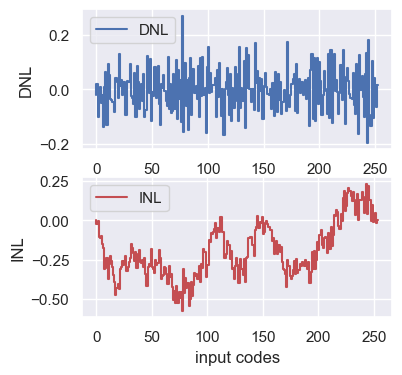

In [721]:
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(dout[0:-1], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(dout, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)

In [722]:
# run a monte carlo simulation to observe the ADCs linearity against the mismatch of the resistors and the offset of the comparators

circuits = 100

# circuit level parameters
vddd = 1.0
vssd = 0.0
vcm = (vddd + vssd)/2
comp_offset = 100e-6 # 500 uV

# setup the adc parameters
nbits = 8
vref = vddd
vlsb = vref/(2**nbits)

# number of simulation points
Np = 2**15
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)
# setup the input codes
A1 = vddd/2
f1 = (Fs/Np) # Hz
ph1 = 0 # rad
ofst = 0.0
vin_t = A1*np.sin(2*np.pi*f1*tD + ph1) + ofst + vcm

# resistance mismatch in ohm, following a normal distribution
ru = 1e3
u_err = 0.0
sigma = 4
u_std = 1/sigma # 33% of the unit resistance for a semiconductor resistor


adc_lins = []

for _ in range(circuits):
    # setup the resistor array
    res = np.ones(2**nbits)*ru
    r_err = normal(u_err, u_std**2, len(res))
    res = res + r_err*ru
    # setup vlsb voltage array from resistor array using a voltage divider
    vcomps = np.array([
        vref*(np.sum(res[0:i+1])/np.sum(res)) for i in range(len(res)-1)
    ])
    # setup the comparator offset array
    comps_ofst = np.random.normal(0, comp_offset**2, len(vcomps))
    comps = vcomps + comps_ofst
    # gen the input voltages and get the output codes
    vin = np.sort(np.unique(vin_t))
    decoder_in = np.array([v > comps for v in vin])
    dout = np.array([np.count_nonzero(din) for din in decoder_in])
    # obtain the transition voltages of the ADC
    vtrans = vin[np.where(np.diff(dout) > 0)]
    dout = dout[np.where(np.diff(dout) > 0)]
    # compute the inl, dnl and the effective number of bits of the ADC
    vlsb_measured = (vtrans[-1] - vtrans[0])/(2**nbits - 2)
    dnl = np.diff(vtrans)/vlsb_measured - 1
    inl = np.array([0] + np.cumsum(dnl).tolist())
    assert len(dnl) == 2**nbits - 2, 'DNL length is not correct: {}'.format(len(dnl))
    assert len(inl) == 2**nbits-1, 'INL length is not correct: {}'.format(len(inl))
    # compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
    # difference between the minimum and maximum value of the INL)
    adc_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
    adc_lins.append(adc_linearity)

Text(0.5, 1.0, 'ADC linearity histogram')

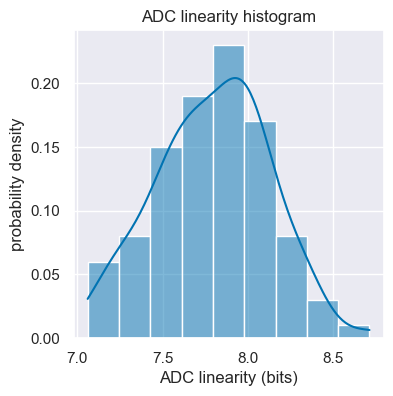

In [723]:
# observe the adc linearity histogram
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(adc_lins, ax=ax, stat="probability", kde=True)
ax.set_xlabel('ADC linearity (bits)')
ax.set_ylabel('probability density')
ax.grid(True)
ax.set_title('ADC linearity histogram')

In [724]:
# compute the average adc linearity against comparator offset, ignoring the resistor mismatch
avg_adc_lins = []
comp_offsets = np.linspace(0, 1e-3, 5)

u_std = 0.00

for comp_offset in comp_offsets:
    adc_lins = []
    for _ in range(circuits):
        # setup the resistor array
        res = np.ones(2**nbits)*ru
        r_err = normal(u_err, u_std**2, len(res))
        res = res + r_err*ru
        # setup vlsb voltage array from resistor array using a voltage divider
        vcomps = np.array([
            vref*(np.sum(res[0:i+1])/np.sum(res)) for i in range(len(res)-1)
        ])
        # setup the comparator offset array
        comps_ofst = np.random.normal(0, comp_offset**2, len(vcomps))
        comps = vcomps + comps_ofst
        # gen the input voltages and get the output codes
        vin = np.sort(np.unique(vin_t))
        decoder_in = np.array([v > comps for v in vin])
        dout = np.array([np.count_nonzero(din) for din in decoder_in])
        # obtain the transition voltages of the ADC
        vtrans = vin[np.where(np.diff(dout) > 0)]
        dout = dout[np.where(np.diff(dout) > 0)]
        # compute the inl, dnl and the effective number of bits of the ADC
        vlsb_measured = (vtrans[-1] - vtrans[0])/(2**nbits - 2)
        dnl = np.diff(vtrans)/vlsb_measured - 1
        inl = np.array([0] + np.cumsum(dnl).tolist())
        assert len(dnl) == 2**nbits - 2, 'DNL length is not correct: {}'.format(len(dnl))
        assert len(inl) == 2**nbits-1, 'INL length is not correct: {}'.format(len(inl))
        # compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
        # difference between the minimum and maximum value of the INL)
        adc_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
        adc_lins.append(adc_linearity)
    avg_adc_lins.append(np.mean(adc_lins))
        

Text(0.5, 1.0, 'ADC linearity against comparator offset')

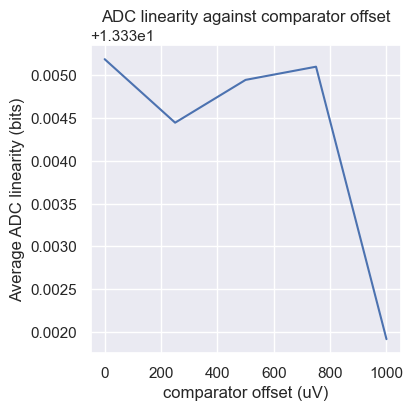

In [725]:
# observe the average adc linearity against resistor mismatch
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(comp_offsets/1e-6, avg_adc_lins, 'b', label='ADC linearity')
ax.set_xlabel('comparator offset (uV)')
ax.set_ylabel('Average ADC linearity (bits)')
ax.grid(True)
ax.set_title('ADC linearity against comparator offset')

<h2 align="left"> Single Comparator Flash ADC </h2>

<p align=justify>
    The number of comparators in a flash ADC grows exponentially with the number of bits of the architecture, and thus it is not feasible to implement a flash ADC with a high number of bits. However, it is possible to implement a flash ADC with a single comparator. By using each individual voltage level from the resistive array, and using sequential control logic to implement a Binary Search Algorithm (Successive Approximations Algorithm), one can determine each bit of the ADC by determining if the input votlage is above or below that level. There is a quite evident tradeoff here - instead of using multiple comparators to obtain the result in a single conversion step, we are using a single comparator to obtain the result in multiple conversion steps.
</p>

# inserir imagem do flash adc com um comparador com esquema de comutaçao

<h2 align="center"> 2-Step Flash ADC (without amplification = Sub-Ranging) </h2>

<p align=justify>
    The 2-step architecture of an ADC is based on the block diagram below. The 2-step architecture can be thought of a prelude for pipeline ADCs, in which the total ADC's resolution is spatially divided between two stages. The first stage will lay out the Most Significant Bits, and the residue of the first stage will be converted in the second stage, laying out the Least Significant Bits of the ADC. Of course that the range of the residue must be adjusted to the resolution of the secodn stage, and for that it is possible to either: 1) adjust the reference voltage of the second stage to a lower value (sub-ranging), 2) amplify the residue by a gain dependant on the resolution of the first stage so that it covers the full covnersion range of the second stage (with amplification), 3) a combination of both (which we call a cheat in the academia).
</p>

# inserir imagem do 2-step flash adc sem amplificacao